In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skvideo.io
import skvideo.datasets
from copy import deepcopy as copy

## Generating Pixels to embed in
This is the 3d Chaotic map used in Hossain et. al

In [52]:
class chaotic_pixels:
    def __init__(self):
        self.x_1 = 0.2350
        self.y_1 = 0.3500
        self.z_1 = 0.7350
        
        self.alpha = 0.0125 # 0 < alpha < 0.015
        self.beta = 0.0157  # 0 < beta < 0.022
        self.gamma = 3.7700 # 3.53 < gamma < 3.81
        
        self.N = 10**8
    
    def logistic_chaos_map(self, xn, yn, zn):
        x = (self.gamma*xn*(1-xn)) + (self.beta*(yn**2)*xn) +(self.alpha*(zn**3))
        y = (self.gamma*yn*(1-yn)) + (self.beta*(zn**2)*yn) +(self.alpha*(xn**3))    
        z = (self.gamma*zn*(1-zn)) + (self.beta*(xn**2)*zn) +(self.alpha*(yn**3))
    
        return x, y, z
    
    def get_pixels(self, video_dims, data_len):
        values = [(self.x_1, self.y_1, self.z_1)]
        for i in range(1, data_len):
            x, y, z = values[-1]
            values.append(self.logistic_chaos_map(x, y, z))
        
        values = np.array(values)
        for i in range (0, 3):
            values[:, i] = np.mod(np.uint64(values[:, i]*self.N), video_dims[i])
            
        return values

## Reading the video

In [9]:
video = skvideo.io.vread("test-720p_1.mp4")

In [10]:
video.shape

(132, 720, 1280, 3)

In [30]:
video[0][0][0]

array([104, 112,  46], dtype=uint8)

In [27]:
MAX_DATA_LEN = np.prod(video.shape)
MAX_DATA_LEN # in bytes

364953600

In [29]:
MAX_DATA_LEN/1024/1024

348.046875

We can encode about 348MB of data in this small video

In [23]:
video_dims = video.shape[0:3]

In [24]:
video_dims

(132, 720, 1280)

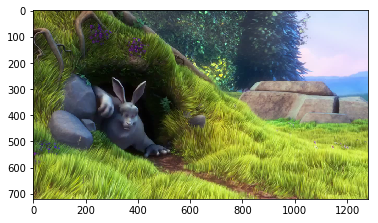

In [25]:
plt.imshow(video[0])

## Getting pixel values for some sample data

In [31]:
import lorem

In [37]:
data = lorem.text()
data

'Etincidunt ipsum dolorem adipisci neque quaerat sit est. Sed voluptatem quaerat quisquam consectetur modi labore dolorem. Tempora tempora sit est quisquam magnam velit. Quiquia magnam porro sed quaerat quaerat voluptatem. Dolor quisquam neque quisquam consectetur sed tempora etincidunt.\n\nDolore velit amet adipisci dolor amet etincidunt. Porro non numquam consectetur dolor. Magnam magnam magnam non aliquam dolore non sed. Neque magnam tempora est sed numquam dolor neque. Numquam velit quisquam numquam. Est eius aliquam est consectetur labore magnam est.\n\nLabore neque quisquam neque est magnam. Sed quaerat sed adipisci adipisci modi ipsum. Magnam sed porro ipsum porro tempora sit. Amet labore etincidunt magnam adipisci. Dolore neque dolore sed. Tempora aliquam dolorem sed.\n\nSit modi ipsum labore. Ipsum consectetur dolore magnam numquam. Dolor numquam neque etincidunt ut. Neque adipisci est quisquam. Etincidunt tempora eius porro numquam numquam. Eius dolor porro neque dolorem aliq

In [41]:
b_data = data.encode('utf-8')

In [43]:
print(type(b_data))

<class 'bytes'>


In [72]:
max(b_data)

118

In [49]:
data_len = len(b_data)
data_len

1530

In [54]:
generator = chaotic_pixels()

In [55]:
pixels_to_encode = generator.get_pixels(video_dims, data_len)

In [57]:
pixels_to_encode.shape

(1530, 3)

`pixels_to_encode` has the locations of the pixels in the video where we wish to encode our information. 

In [62]:
pixels_to_encode.min(axis = 0), pixels_to_encode.max(axis = 0)

(array([0., 0., 0.]), array([ 131.,  719., 1276.]))

In [65]:
len(np.unique(pixels_to_encode, axis = 1))

1530

This shows that every pixel location is unique

## LSB Substitution

We're going to be employing the 3-3-2 LSB substitution. 3 lsb of red, 3 in green and 2 in blue.

In [99]:
format(118, '08b')

'01110110'

In [97]:
def lsb_sub_332(pixel, value):
    bits = format(value, '08b')
    
#     print(bits)
#     for i in pixel:
#         print(format(i, '08b'))
    
    pixel[0] &= 248
    pixel[1] &= 248
    pixel[2] &= 252
    
    for i in range(0, 3):
        pixel[0] = pixel[0] | (int(bits[i]) << (2-i))
    
    for i in range(3, 6):
        pixel[1] = pixel[1] | (int(bits[i]) << (5-i))
    
    for i in range(6, 8):
        pixel[2] = pixel[2] | (int(bits[i]) << (7-i))
    
#     for i in pixel:
#         print(format(i, '08b'))
    
    return pixel

In [98]:
lsb_sub_332([123, 210, 215], 118)

[123, 213, 214]

## Encoding the data into the frames

In [100]:
encoded_video = copy(video)

In [109]:
x, y, z = pixels_to_encode[0]

In [111]:
video[int(x)][int(y)][int(z)]

array([221, 230, 253], dtype=uint8)

In [112]:
for i in range(0, data_len):
    x, y, z = pixels_to_encode[i]
    x, y, z = int(x), int(y), int(z)
    encoded_video[x][y][z] = lsb_sub_332(encoded_video[x][y][z], b_data[i])

In [114]:
x, y, z = pixels_to_encode[0]
x, y, z = int(x), int(y), int(z)

In [116]:
video[x][y][z], encoded_video[x][y][z], b_data[0]

(array([221, 230, 253], dtype=uint8), array([218, 225, 253], dtype=uint8), 69)

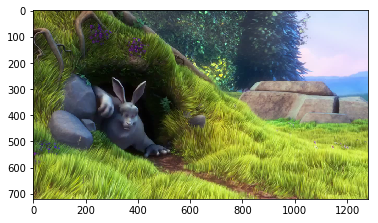

In [117]:
plt.imshow(video[0])

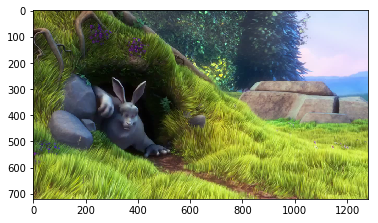

In [118]:
plt.imshow(encoded_video[0])

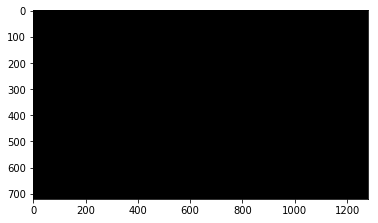

In [122]:
plt.imshow(np.absolute(video[0] - encoded_video[0]))